In [ ]:
#Import The Solar Flare Data Set Files


labelFile="Data\\labels_1540_4classes_icmla_21.pck"
inputsFile="Data\\mvts_1540_icmla_21.pck"

--2022-07-14 07:03:46--  https://www.dropbox.com/s/uy58al2rwf6yn9u/labels_1540_4classes_icmla_21.pck
Resolving www.dropbox.com (www.dropbox.com)... 162.125.64.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.64.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/uy58al2rwf6yn9u/labels_1540_4classes_icmla_21.pck [following]
--2022-07-14 07:03:47--  https://www.dropbox.com/s/raw/uy58al2rwf6yn9u/labels_1540_4classes_icmla_21.pck
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucbd0a4b82fe5415943d30f6bb8d.dl.dropboxusercontent.com/cd/0/inline/BpAkGCoFwWMJaQbUUDA40idcR1c-e_jNo5gusEJlx50IaWsyWgpWyv4MRC9D3NjPs01pR4pMb3btYZQxduuv531Y_cxNJJVjufv-0LJDPr0wuSmdIRZBx1op4m6PozLutgE9DlzGC26Z0t58IMwsiKXYpfe4N_F2WqDJxSP9V5GLZQ/file# [following]
--2022-07-14 07:03:47--  https://ucbd0a4b82fe5415943d30f6bb8d.dl.dropboxusercontent.com/cd/0/inline/Bp

In [ ]:
import json
import pandas as pd
from datetime import datetime
import pickle

import numpy as np
from numpy import array


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, adjusted_rand_score,classification_report
from sklearn.preprocessing import StandardScaler


import random
import matplotlib.pyplot as plt

torch.manual_seed(1)

In [ ]:
# input_dim = 1, hidden_dim = 128, num_TS = 60, num_classes = 4
class LSTM_UTS_LRN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(LSTM_UTS_LRN, self).__init__()
        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(input_dim, hidden_dim)
        self.hidden2class = nn.Linear(hidden_dim, num_classes)

    def forward(self, uts):
        lstm_out, _ = self.lstm(uts.view(len(uts), 1, -1))  
        last_lstm_out = lstm_out[len(lstm_out) - 1]  
        class_space = self.hidden2class(last_lstm_out)  
        class_scores = F.log_softmax(class_space, dim=1)
        return class_scores

In [ ]:
def doClassSpecificCalulcation(Accuracy,trainLebel,classification_report_dict):
  #print("Accuracy.shape",Accuracy.co)
  print("Accuracy",Accuracy)
  print('\np.max(Accuracy) :',np.max(Accuracy))
  print('\np.mean(Accuracy) :',np.mean(Accuracy))
  print('\np.std(Accuracy) :',np.std(Accuracy))
  print('\n p.mean np.std(Accuracy) : ',np.round(np.mean(Accuracy),2),"+-",np.round(np.std(Accuracy),2) )
  print('\n p.max np.std(Accuracy) : ',np.round(np.max(Accuracy),2),"+-",np.round(np.std(Accuracy),2) )
  for j in range( len(np.unique(trainLebel)) ):
    print('\n\n\n\nclass :',j)
    precision=[]
    recall=[]
    f1_score=[]
    for i in range(len(classification_report_dict)):
      report=classification_report_dict[i]
      temp=report[str(j)]['precision']
      precision.append(temp)

      temp=report[str(j)]['recall']
      recall.append(temp)

      temp=report[str(j)]['f1-score']
      f1_score.append(temp)

    print('\np.mean(precision) \t p.mean(recall) \t p.mean(f1_score) :')


    print(np.mean(precision))
    print(np.mean(recall))
    print(np.mean(f1_score))

    print('\np.mean p.std(precision) \tp.mean  p.std(recall) \tp.mean  p.std(f1_score) :')

    print(np.round(np.mean(precision),2),"+-",np.round(np.std(precision),2) )
    print(np.round(np.mean(recall),2),"+-",np.round(np.std(recall),2) )
    print(np.round(np.mean(f1_score),2),"+-",np.round(np.std(f1_score),2) )

In [ ]:
def startCalculations( X_train, X_test, y_train, y_test,HIDDEN_DIM,num_masterIteration,numEpochs):

    classification_report_dict=[]
    
    for masterIteration in range(num_masterIteration):
        print("\n masterIteration HIDDEN_DIM : ",masterIteration, HIDDEN_DIM)

        model = LSTM_UTS_LRN(INPUT_DIM,HIDDEN_DIM,NUM_CLASSES)
        loss_function = nn.NLLLoss()
        optimizer = optim.SGD(model.parameters(), lr=0.01)
        numTrain = X_train.shape[0]

        #train
        numParams=25
        for colId in range(numParams):
         accuracy=[]
         maxAcc=0
         max_classification_report_dict=0 
         for epoch in range(numEpochs):
          print("\n nmasterIteration, epoch: ",masterIteration,epoch)
          loss_values = []
          running_loss = 0.0

          for i in range(numTrain):
            model.zero_grad()
            mvts = X_train[i,:,:]
            ts = mvts[:, colId]
            ts = torch.from_numpy(ts).float()
            target = y_train[i]
            target = [target]
            target=np.array(target)
            target = torch.Tensor(target)
            target = target.type(torch.LongTensor)
            #ts = ts.to(device)
            #target = target.to(device)
            ts = ts.view(ts.size(0), -1)
            #model.to(device)
            class_scores = model(ts)
            loss = loss_function(class_scores, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            loss_values.append(running_loss / len(X_train))
 
          #test
          numTest = X_test.shape[0]
          with torch.no_grad():
              numCorrect = 0
              testLabel=[]
              predictaedLabel=[]
              for i in range(numTest):
                test_mvts = X_test[i,:,:]
                test_ts = test_mvts[:, colId]
                test_label = y_test[i] 
                test_ts = torch.from_numpy(test_ts).float()
                #test_ts = test_ts.to(device)
                test_class_scores = model(test_ts) 
                class_prediction = torch.argmax(test_class_scores, dim=-1) 
                current_seq = np.argmax(test_class_scores.cpu().numpy())
                testLabel.append(test_label)
                predictaedLabel.append(current_seq)
                if(class_prediction == test_label): #(2,3 ) match
                  numCorrect = numCorrect+1
              acc = numCorrect/numTest
              print( "Acc:",acc)
              #temp=round(acc, 2)
              #temp=acc
              accuracy.append(acc)       
         print( "maxAcc:",colId+1,":" ,max(accuracy))
         maxAcc=max(accuracy)
         max_classification_report_dict=metrics.classification_report(testLabel, predictaedLabel, digits=3,output_dict=True)

         plt.plot(np.array(loss_values), 'r')
         classification_report_dict.append(max_classification_report_dict)
         Accuracy.append(maxAcc)
         print( "classification Report for Parameter Number:",colId+1,":" ,maxAcc)
         doClassSpecificCalulcation(accuracy,trainLabel,classification_report_dict)
        



In [ ]:
def loadInputs(file_name):
        with open(file_name, 'rb') as fp:
            obj = pickle.load(fp)
        return obj

In [ ]:
#device = torch.device('cpu')
#print("Processing in :",device)

Sampled_inputs=loadInputs("mvts_1540_icmla_21.pck")
Sampled_labels=loadInputs("labels_1540_4classes_icmla_21.pck") 
trainData = Sampled_inputs
trainLabel = Sampled_labels
print("trainData.shape: ", trainData.shape)
print("trainLebel.shape: ", trainLabel.shape)
print("Classes/labels : ",np.unique(trainLabel))

trainData.shape:  (1540, 33, 60)
trainLebel.shape:  (1540,)
Classes/labels :  [0 1 2 3]


In [ ]:
#standardization/z normalization of the univaraite time series
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
npArrays=[]
for l in range(0, len(trainData)):
  trainData_std = sc.fit_transform(trainData[l])
  #trainData_std = trainData_std.astype(np.float64)
  #print(type(trainData_std[0][0]))
  npArrays.append(trainData_std)

print(type(npArrays))
arr = np.asarray(npArrays)
print(type(arr))
trainData=arr
print("trainData.shape: ",trainData.shape)
print(type(trainData))
print("trainLebel.shape: ",trainLabel.shape)
print(type(trainLabel))

<class 'list'>
<class 'numpy.ndarray'>
trainData.shape:  (1540, 33, 60)
<class 'numpy.ndarray'>
trainLebel.shape:  (1540,)
<class 'numpy.ndarray'>


In [ ]:
#Transposing trainData to shape:(1540, 60, 33)
trainDatatemp=np.empty([1540,60, 33])
n=len(trainData)
for l in range(0, n):
  temp=trainData[l]
  temp=temp.T
  trainDatatemp[l,:,:]=temp
  

trainData=trainDatatemp
print("Transposing trainData shape: ",trainData.shape)

Transposing trainData shape:  (1540, 60, 33)


In [ ]:
#Taking the first 25 parameters which are based parameters:(1540, 60, 25)
trainDatat1=np.empty([1540,60, 25])
n=len(trainData)
for l in range(0, n):
  temp=trainData[l,:,0:25]
  trainDatat1[l,:,:]=temp
  

trainData=trainDatat1
print("trainData shape: ",trainData.shape)

trainData shape:  (1540, 60, 25)


In [ ]:
# Stratify the data
from sklearn.model_selection import train_test_split
mvts_1540=trainData
labels_1540=trainLabel
X_train, X_test, y_train, y_test = train_test_split(mvts_1540, labels_1540, test_size=0.3, random_state=0, stratify=labels_1540)
print("X_train.shape y_train.shape y_test.shape ",X_train.shape, y_train.shape)
print("X_test.shape y_test.shape ",X_test.shape, y_test.shape)

X_train.shape y_train.shape y_test.shape  (1078, 60, 25) (1078,)
X_test.shape y_test.shape  (462, 60, 25) (462,)


In [ ]:
#check percentage of examples
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)
unique_y_train, counts_y_train = np.unique(y_train, return_counts=True)
y_train_stats = dict(zip(unique_y_train, counts_y_train))
print("y_train_counts")
print(y_train_stats)
#270/(269+269+270+270) = 0.25
unique_y_test, counts_y_test = np.unique(y_test, return_counts=True)
y_test_stats = dict(zip(unique_y_test, counts_y_test))
print("y_test_counts")
print(y_test_stats)
#116/(116+116+115+115) = 0.25

X_train shape:  (1078, 60, 25)
y_train shape:  (1078,)
X_test shape:  (462, 60, 25)
y_test shape:  (462,)
y_train_counts
{0: 269, 1: 269, 2: 270, 3: 270}
y_test_counts
{0: 116, 1: 116, 2: 115, 3: 115}


In [ ]:
def start(validation_sizes,HIDDEN_DIMs,num_masterIteration,numEpochs):

    for temp in range(len(validation_sizes)):
        validation_size = validation_sizes[temp]
        print("\n\n\n *************** Validation Size is: ", validation_sizes,"of training size")
        random_state = 1 
        print("random_state: ", random_state)

        Xtrain, Xval, ytrain, yval = train_test_split(X_train,y_train, test_size=validation_size,
                                                            random_state=random_state)

        print("X_train.shape Xval.shape y_train.shape yval.shape ",
              X_train.shape, Xval.shape, y_train.shape, yval.shape)


        for temp5 in range(len(HIDDEN_DIMs)):
            hds = HIDDEN_DIMs[temp5]
            startCalculations(Xtrain, Xval, ytrain, yval, hds,num_masterIteration,numEpochs)




 *************** Validation Size is:  [0.2] of training size
random_state:  1
X_train.shape Xval.shape y_train.shape yval.shape  (1078, 60, 25) (216, 60, 25) (1078,) (216,)

 masterIteration HIDDEN_DIM :  0 128

 nmasterIteration, epoch:  0 0
Acc: 0.19907407407407407

 nmasterIteration, epoch:  0 1
Acc: 0.19907407407407407

 nmasterIteration, epoch:  0 2
Acc: 0.19907407407407407

 nmasterIteration, epoch:  0 3
Acc: 0.19907407407407407

 nmasterIteration, epoch:  0 4
Acc: 0.19907407407407407

 nmasterIteration, epoch:  0 5
Acc: 0.19907407407407407

 nmasterIteration, epoch:  0 6
Acc: 0.19907407407407407

 nmasterIteration, epoch:  0 7
Acc: 0.19907407407407407

 nmasterIteration, epoch:  0 8
Acc: 0.19907407407407407

 nmasterIteration, epoch:  0 9
Acc: 0.19907407407407407

 nmasterIteration, epoch:  0 10
Acc: 0.19907407407407407

 nmasterIteration, epoch:  0 11
Acc: 0.19907407407407407

 nmasterIteration, epoch:  0 12
Acc: 0.19907407407407407

 nmasterIteration, epoch:  0 13
Acc: 0.19

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Acc: 0.19907407407407407

 nmasterIteration, epoch:  0 1
Acc: 0.19907407407407407

 nmasterIteration, epoch:  0 2
Acc: 0.19907407407407407

 nmasterIteration, epoch:  0 3
Acc: 0.19907407407407407

 nmasterIteration, epoch:  0 4
Acc: 0.19907407407407407

 nmasterIteration, epoch:  0 5
Acc: 0.19907407407407407

 nmasterIteration, epoch:  0 6
Acc: 0.19907407407407407

 nmasterIteration, epoch:  0 7
Acc: 0.19907407407407407

 nmasterIteration, epoch:  0 8
Acc: 0.19907407407407407

 nmasterIteration, epoch:  0 9
Acc: 0.19907407407407407

 nmasterIteration, epoch:  0 10
Acc: 0.19907407407407407

 nmasterIteration, epoch:  0 11
Acc: 0.19907407407407407

 nmasterIteration, epoch:  0 12
Acc: 0.19907407407407407

 nmasterIteration, epoch:  0 13
Acc: 0.19907407407407407

 nmasterIteration, epoch:  0 14
Acc: 0.19907407407407407

 nmasterIteration, epoch:  0 15
Acc: 0.2037037037037037

 nmasterIteration, epoch:  0 16
Acc: 0.2037037037037037

 nmasterIteration, epoch:  0 17
Acc: 0.2037037037037037



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Acc: 0.2962962962962963

 nmasterIteration, epoch:  0 1
Acc: 0.35185185185185186

 nmasterIteration, epoch:  0 2
Acc: 0.4027777777777778

 nmasterIteration, epoch:  0 3
Acc: 0.4583333333333333

 nmasterIteration, epoch:  0 4
Acc: 0.46296296296296297

 nmasterIteration, epoch:  0 5
Acc: 0.4722222222222222

 nmasterIteration, epoch:  0 6
Acc: 0.48148148148148145

 nmasterIteration, epoch:  0 7
Acc: 0.48148148148148145

 nmasterIteration, epoch:  0 8
Acc: 0.48148148148148145

 nmasterIteration, epoch:  0 9
Acc: 0.4675925925925926

 nmasterIteration, epoch:  0 10
Acc: 0.46296296296296297

 nmasterIteration, epoch:  0 11
Acc: 0.4583333333333333

 nmasterIteration, epoch:  0 12
Acc: 0.4583333333333333

 nmasterIteration, epoch:  0 13
Acc: 0.4583333333333333

 nmasterIteration, epoch:  0 14
Acc: 0.4537037037037037

 nmasterIteration, epoch:  0 15
Acc: 0.4537037037037037

 nmasterIteration, epoch:  0 16
Acc: 0.4537037037037037

 nmasterIteration, epoch:  0 17
Acc: 0.4583333333333333

 nmasterI

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Acc: 0.2962962962962963

 nmasterIteration, epoch:  0 1
Acc: 0.2962962962962963

 nmasterIteration, epoch:  0 2
Acc: 0.2916666666666667

 nmasterIteration, epoch:  0 3
Acc: 0.2916666666666667

 nmasterIteration, epoch:  0 4
Acc: 0.28703703703703703

 nmasterIteration, epoch:  0 5
Acc: 0.2824074074074074

 nmasterIteration, epoch:  0 6
Acc: 0.2824074074074074

 nmasterIteration, epoch:  0 7
Acc: 0.28703703703703703

 nmasterIteration, epoch:  0 8
Acc: 0.2824074074074074

 nmasterIteration, epoch:  0 9
Acc: 0.28703703703703703

 nmasterIteration, epoch:  0 10
Acc: 0.2777777777777778

 nmasterIteration, epoch:  0 11
Acc: 0.2638888888888889

 nmasterIteration, epoch:  0 12
Acc: 0.25925925925925924

 nmasterIteration, epoch:  0 13
Acc: 0.25925925925925924

 nmasterIteration, epoch:  0 14
Acc: 0.2638888888888889

 nmasterIteration, epoch:  0 15
Acc: 0.2638888888888889

 nmasterIteration, epoch:  0 16
Acc: 0.25462962962962965

 nmasterIteration, epoch:  0 17
Acc: 0.25462962962962965

 nmaster

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Acc: 0.25

 nmasterIteration, epoch:  0 1
Acc: 0.24537037037037038

 nmasterIteration, epoch:  0 2
Acc: 0.25

 nmasterIteration, epoch:  0 3
Acc: 0.24537037037037038

 nmasterIteration, epoch:  0 4
Acc: 0.24074074074074073

 nmasterIteration, epoch:  0 5
Acc: 0.2361111111111111

 nmasterIteration, epoch:  0 6
Acc: 0.2361111111111111

 nmasterIteration, epoch:  0 7
Acc: 0.2361111111111111

 nmasterIteration, epoch:  0 8
Acc: 0.23148148148148148

 nmasterIteration, epoch:  0 9
Acc: 0.23148148148148148

 nmasterIteration, epoch:  0 10
Acc: 0.23148148148148148

 nmasterIteration, epoch:  0 11
Acc: 0.23148148148148148

 nmasterIteration, epoch:  0 12
Acc: 0.23148148148148148

 nmasterIteration, epoch:  0 13
Acc: 0.23148148148148148

 nmasterIteration, epoch:  0 14
Acc: 0.22685185185185186

 nmasterIteration, epoch:  0 15
Acc: 0.22685185185185186

 nmasterIteration, epoch:  0 16
Acc: 0.22685185185185186

 nmasterIteration, epoch:  0 17
Acc: 0.22685185185185186

 nmasterIteration, epoch:  0 1

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Acc: 0.2824074074074074

 nmasterIteration, epoch:  0 1
Acc: 0.2962962962962963

 nmasterIteration, epoch:  0 2
Acc: 0.2962962962962963

 nmasterIteration, epoch:  0 3
Acc: 0.3148148148148148

 nmasterIteration, epoch:  0 4
Acc: 0.3101851851851852

 nmasterIteration, epoch:  0 5
Acc: 0.3148148148148148

 nmasterIteration, epoch:  0 6
Acc: 0.32407407407407407

 nmasterIteration, epoch:  0 7
Acc: 0.32407407407407407

 nmasterIteration, epoch:  0 8
Acc: 0.3194444444444444

 nmasterIteration, epoch:  0 9
Acc: 0.32407407407407407

 nmasterIteration, epoch:  0 10
Acc: 0.32407407407407407

 nmasterIteration, epoch:  0 11
Acc: 0.3287037037037037

 nmasterIteration, epoch:  0 12
Acc: 0.3333333333333333

 nmasterIteration, epoch:  0 13
Acc: 0.3287037037037037

 nmasterIteration, epoch:  0 14
Acc: 0.3287037037037037

 nmasterIteration, epoch:  0 15
Acc: 0.3287037037037037

 nmasterIteration, epoch:  0 16
Acc: 0.3287037037037037

 nmasterIteration, epoch:  0 17
Acc: 0.32407407407407407

 nmasterIt

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Acc: 0.2222222222222222

 nmasterIteration, epoch:  0 1
Acc: 0.2222222222222222

 nmasterIteration, epoch:  0 2
Acc: 0.2222222222222222

 nmasterIteration, epoch:  0 3
Acc: 0.2222222222222222

 nmasterIteration, epoch:  0 4
Acc: 0.2222222222222222

 nmasterIteration, epoch:  0 5
Acc: 0.25925925925925924

 nmasterIteration, epoch:  0 6
Acc: 0.3055555555555556

 nmasterIteration, epoch:  0 7
Acc: 0.3194444444444444

 nmasterIteration, epoch:  0 8
Acc: 0.3194444444444444

 nmasterIteration, epoch:  0 9
Acc: 0.3287037037037037

 nmasterIteration, epoch:  0 10
Acc: 0.3333333333333333

 nmasterIteration, epoch:  0 11
Acc: 0.3425925925925926

 nmasterIteration, epoch:  0 12
Acc: 0.3287037037037037

 nmasterIteration, epoch:  0 13
Acc: 0.3101851851851852

 nmasterIteration, epoch:  0 14
Acc: 0.3055555555555556

 nmasterIteration, epoch:  0 15
Acc: 0.2962962962962963

 nmasterIteration, epoch:  0 16
Acc: 0.2962962962962963

 nmasterIteration, epoch:  0 17
Acc: 0.30092592592592593

 nmasterItera

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Acc: 0.19907407407407407

 nmasterIteration, epoch:  0 1
Acc: 0.2037037037037037

 nmasterIteration, epoch:  0 2
Acc: 0.2037037037037037

 nmasterIteration, epoch:  0 3
Acc: 0.18518518518518517

 nmasterIteration, epoch:  0 4
Acc: 0.18981481481481483

 nmasterIteration, epoch:  0 5
Acc: 0.19907407407407407

 nmasterIteration, epoch:  0 6
Acc: 0.19907407407407407

 nmasterIteration, epoch:  0 7
Acc: 0.2037037037037037

 nmasterIteration, epoch:  0 8
Acc: 0.20833333333333334

 nmasterIteration, epoch:  0 9
Acc: 0.21296296296296297

 nmasterIteration, epoch:  0 10
Acc: 0.2175925925925926

 nmasterIteration, epoch:  0 11
Acc: 0.2222222222222222

 nmasterIteration, epoch:  0 12
Acc: 0.22685185185185186

 nmasterIteration, epoch:  0 13
Acc: 0.22685185185185186

 nmasterIteration, epoch:  0 14
Acc: 0.2222222222222222

 nmasterIteration, epoch:  0 15
Acc: 0.2222222222222222

 nmasterIteration, epoch:  0 16
Acc: 0.22685185185185186

 nmasterIteration, epoch:  0 17
Acc: 0.22685185185185186

 nma

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Acc: 0.22685185185185186

 nmasterIteration, epoch:  0 1
Acc: 0.2222222222222222

 nmasterIteration, epoch:  0 2
Acc: 0.19444444444444445

 nmasterIteration, epoch:  0 3
Acc: 0.2037037037037037

 nmasterIteration, epoch:  0 4
Acc: 0.22685185185185186

 nmasterIteration, epoch:  0 5
Acc: 0.25

 nmasterIteration, epoch:  0 6
Acc: 0.2638888888888889

 nmasterIteration, epoch:  0 7
Acc: 0.26851851851851855

 nmasterIteration, epoch:  0 8
Acc: 0.27314814814814814

 nmasterIteration, epoch:  0 9
Acc: 0.28703703703703703

 nmasterIteration, epoch:  0 10
Acc: 0.3055555555555556

 nmasterIteration, epoch:  0 11
Acc: 0.3055555555555556

 nmasterIteration, epoch:  0 12
Acc: 0.3055555555555556

 nmasterIteration, epoch:  0 13
Acc: 0.3055555555555556

 nmasterIteration, epoch:  0 14
Acc: 0.3148148148148148

 nmasterIteration, epoch:  0 15
Acc: 0.3194444444444444

 nmasterIteration, epoch:  0 16
Acc: 0.32407407407407407

 nmasterIteration, epoch:  0 17
Acc: 0.3101851851851852

 nmasterIteration, epo

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Acc: 0.3194444444444444

 nmasterIteration, epoch:  0 1
Acc: 0.3055555555555556

 nmasterIteration, epoch:  0 2
Acc: 0.3287037037037037

 nmasterIteration, epoch:  0 3
Acc: 0.3287037037037037

 nmasterIteration, epoch:  0 4
Acc: 0.3287037037037037

 nmasterIteration, epoch:  0 5
Acc: 0.32407407407407407

 nmasterIteration, epoch:  0 6
Acc: 0.3287037037037037

 nmasterIteration, epoch:  0 7
Acc: 0.3287037037037037

 nmasterIteration, epoch:  0 8
Acc: 0.32407407407407407

 nmasterIteration, epoch:  0 9
Acc: 0.33796296296296297

 nmasterIteration, epoch:  0 10
Acc: 0.3287037037037037

 nmasterIteration, epoch:  0 11
Acc: 0.32407407407407407

 nmasterIteration, epoch:  0 12
Acc: 0.3333333333333333

 nmasterIteration, epoch:  0 13
Acc: 0.30092592592592593

 nmasterIteration, epoch:  0 14
Acc: 0.30092592592592593

 nmasterIteration, epoch:  0 15
Acc: 0.30092592592592593

 nmasterIteration, epoch:  0 16
Acc: 0.30092592592592593

 nmasterIteration, epoch:  0 17
Acc: 0.2962962962962963

 nmaste

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Acc: 0.2777777777777778

 nmasterIteration, epoch:  0 1
Acc: 0.2962962962962963

 nmasterIteration, epoch:  0 2
Acc: 0.28703703703703703

 nmasterIteration, epoch:  0 3
Acc: 0.28703703703703703

 nmasterIteration, epoch:  0 4
Acc: 0.2916666666666667

 nmasterIteration, epoch:  0 5
Acc: 0.3101851851851852

 nmasterIteration, epoch:  0 6
Acc: 0.30092592592592593

 nmasterIteration, epoch:  0 7
Acc: 0.30092592592592593

 nmasterIteration, epoch:  0 8
Acc: 0.3287037037037037

 nmasterIteration, epoch:  0 9
Acc: 0.3148148148148148

 nmasterIteration, epoch:  0 10
Acc: 0.3101851851851852

 nmasterIteration, epoch:  0 11
Acc: 0.3055555555555556

 nmasterIteration, epoch:  0 12
Acc: 0.32407407407407407

 nmasterIteration, epoch:  0 13
Acc: 0.3333333333333333

 nmasterIteration, epoch:  0 14
Acc: 0.3101851851851852

 nmasterIteration, epoch:  0 15
Acc: 0.3148148148148148

 nmasterIteration, epoch:  0 16
Acc: 0.32407407407407407

 nmasterIteration, epoch:  0 17
Acc: 0.3055555555555556

 nmasterI

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Acc: 0.32407407407407407

 nmasterIteration, epoch:  0 1
Acc: 0.3287037037037037

 nmasterIteration, epoch:  0 2
Acc: 0.3194444444444444

 nmasterIteration, epoch:  0 3
Acc: 0.30092592592592593

 nmasterIteration, epoch:  0 4
Acc: 0.32407407407407407

 nmasterIteration, epoch:  0 5
Acc: 0.3287037037037037

 nmasterIteration, epoch:  0 6
Acc: 0.3333333333333333

 nmasterIteration, epoch:  0 7
Acc: 0.30092592592592593

 nmasterIteration, epoch:  0 8
Acc: 0.30092592592592593

 nmasterIteration, epoch:  0 9
Acc: 0.30092592592592593

 nmasterIteration, epoch:  0 10
Acc: 0.3055555555555556

 nmasterIteration, epoch:  0 11
Acc: 0.3055555555555556

 nmasterIteration, epoch:  0 12
Acc: 0.3055555555555556

 nmasterIteration, epoch:  0 13
Acc: 0.3148148148148148

 nmasterIteration, epoch:  0 14
Acc: 0.3194444444444444

 nmasterIteration, epoch:  0 15
Acc: 0.3101851851851852

 nmasterIteration, epoch:  0 16
Acc: 0.3055555555555556

 nmasterIteration, epoch:  0 17
Acc: 0.24074074074074073

 nmaster

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Acc: 0.30092592592592593

 nmasterIteration, epoch:  0 1
Acc: 0.2962962962962963

 nmasterIteration, epoch:  0 2
Acc: 0.3194444444444444

 nmasterIteration, epoch:  0 3
Acc: 0.3287037037037037

 nmasterIteration, epoch:  0 4
Acc: 0.3287037037037037

 nmasterIteration, epoch:  0 5
Acc: 0.3194444444444444

 nmasterIteration, epoch:  0 6
Acc: 0.3194444444444444

 nmasterIteration, epoch:  0 7
Acc: 0.3194444444444444

 nmasterIteration, epoch:  0 8
Acc: 0.3101851851851852

 nmasterIteration, epoch:  0 9
Acc: 0.3194444444444444

 nmasterIteration, epoch:  0 10
Acc: 0.32407407407407407

 nmasterIteration, epoch:  0 11
Acc: 0.3148148148148148

 nmasterIteration, epoch:  0 12
Acc: 0.2361111111111111

 nmasterIteration, epoch:  0 13
Acc: 0.3148148148148148

 nmasterIteration, epoch:  0 14
Acc: 0.3194444444444444

 nmasterIteration, epoch:  0 15
Acc: 0.3148148148148148

 nmasterIteration, epoch:  0 16
Acc: 0.3287037037037037

 nmasterIteration, epoch:  0 17
Acc: 0.3055555555555556

 nmasterItera

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Acc: 0.3101851851851852

 nmasterIteration, epoch:  0 1
Acc: 0.3194444444444444

 nmasterIteration, epoch:  0 2
Acc: 0.3055555555555556

 nmasterIteration, epoch:  0 3
Acc: 0.3101851851851852

 nmasterIteration, epoch:  0 4
Acc: 0.3148148148148148

 nmasterIteration, epoch:  0 5
Acc: 0.3194444444444444

 nmasterIteration, epoch:  0 6
Acc: 0.32407407407407407

 nmasterIteration, epoch:  0 7
Acc: 0.3148148148148148

 nmasterIteration, epoch:  0 8
Acc: 0.3148148148148148

 nmasterIteration, epoch:  0 9
Acc: 0.3194444444444444

 nmasterIteration, epoch:  0 10
Acc: 0.2962962962962963

 nmasterIteration, epoch:  0 11
Acc: 0.3101851851851852

 nmasterIteration, epoch:  0 12
Acc: 0.3101851851851852

 nmasterIteration, epoch:  0 13
Acc: 0.3148148148148148

 nmasterIteration, epoch:  0 14
Acc: 0.3148148148148148

 nmasterIteration, epoch:  0 15
Acc: 0.3101851851851852

 nmasterIteration, epoch:  0 16
Acc: 0.3148148148148148

 nmasterIteration, epoch:  0 17
Acc: 0.2916666666666667

 nmasterIterat

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Acc: 0.30092592592592593

 nmasterIteration, epoch:  0 1
Acc: 0.2962962962962963

 nmasterIteration, epoch:  0 2
Acc: 0.28703703703703703

 nmasterIteration, epoch:  0 3
Acc: 0.2777777777777778

 nmasterIteration, epoch:  0 4
Acc: 0.25925925925925924

 nmasterIteration, epoch:  0 5
Acc: 0.25925925925925924

 nmasterIteration, epoch:  0 6
Acc: 0.25925925925925924

 nmasterIteration, epoch:  0 7
Acc: 0.25925925925925924

 nmasterIteration, epoch:  0 8
Acc: 0.26851851851851855

 nmasterIteration, epoch:  0 9
Acc: 0.2638888888888889

 nmasterIteration, epoch:  0 10
Acc: 0.27314814814814814

 nmasterIteration, epoch:  0 11
Acc: 0.2824074074074074

 nmasterIteration, epoch:  0 12
Acc: 0.2916666666666667

 nmasterIteration, epoch:  0 13
Acc: 0.2962962962962963

 nmasterIteration, epoch:  0 14
Acc: 0.30092592592592593

 nmasterIteration, epoch:  0 15
Acc: 0.30092592592592593

 nmasterIteration, epoch:  0 16
Acc: 0.3055555555555556

 nmasterIteration, epoch:  0 17
Acc: 0.3148148148148148

 nmas

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Acc: 0.32407407407407407

 nmasterIteration, epoch:  0 1
Acc: 0.3194444444444444

 nmasterIteration, epoch:  0 2
Acc: 0.3148148148148148

 nmasterIteration, epoch:  0 3
Acc: 0.3148148148148148

 nmasterIteration, epoch:  0 4
Acc: 0.3287037037037037

 nmasterIteration, epoch:  0 5
Acc: 0.3194444444444444

 nmasterIteration, epoch:  0 6
Acc: 0.3287037037037037

 nmasterIteration, epoch:  0 7
Acc: 0.3333333333333333

 nmasterIteration, epoch:  0 8
Acc: 0.3194444444444444

 nmasterIteration, epoch:  0 9
Acc: 0.3194444444444444

 nmasterIteration, epoch:  0 10
Acc: 0.3194444444444444

 nmasterIteration, epoch:  0 11
Acc: 0.3194444444444444

 nmasterIteration, epoch:  0 12
Acc: 0.3287037037037037

 nmasterIteration, epoch:  0 13
Acc: 0.32407407407407407

 nmasterIteration, epoch:  0 14
Acc: 0.32407407407407407

 nmasterIteration, epoch:  0 15
Acc: 0.32407407407407407

 nmasterIteration, epoch:  0 16
Acc: 0.32407407407407407

 nmasterIteration, epoch:  0 17
Acc: 0.3194444444444444

 nmasterIt

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Acc: 0.28703703703703703

 nmasterIteration, epoch:  0 1
Acc: 0.26851851851851855

 nmasterIteration, epoch:  0 2
Acc: 0.2638888888888889

 nmasterIteration, epoch:  0 3
Acc: 0.2638888888888889

 nmasterIteration, epoch:  0 4
Acc: 0.26851851851851855

 nmasterIteration, epoch:  0 5
Acc: 0.2777777777777778

 nmasterIteration, epoch:  0 6
Acc: 0.2824074074074074

 nmasterIteration, epoch:  0 7
Acc: 0.2962962962962963

 nmasterIteration, epoch:  0 8
Acc: 0.30092592592592593

 nmasterIteration, epoch:  0 9
Acc: 0.2962962962962963

 nmasterIteration, epoch:  0 10
Acc: 0.2962962962962963

 nmasterIteration, epoch:  0 11
Acc: 0.2962962962962963

 nmasterIteration, epoch:  0 12
Acc: 0.2916666666666667

 nmasterIteration, epoch:  0 13
Acc: 0.30092592592592593

 nmasterIteration, epoch:  0 14
Acc: 0.30092592592592593

 nmasterIteration, epoch:  0 15
Acc: 0.3055555555555556

 nmasterIteration, epoch:  0 16
Acc: 0.3055555555555556

 nmasterIteration, epoch:  0 17
Acc: 0.30092592592592593

 nmaster

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Acc: 0.3287037037037037

 nmasterIteration, epoch:  0 1
Acc: 0.3287037037037037

 nmasterIteration, epoch:  0 2
Acc: 0.32407407407407407

 nmasterIteration, epoch:  0 3
Acc: 0.3287037037037037

 nmasterIteration, epoch:  0 4
Acc: 0.3287037037037037

 nmasterIteration, epoch:  0 5
Acc: 0.3287037037037037

 nmasterIteration, epoch:  0 6
Acc: 0.3287037037037037

 nmasterIteration, epoch:  0 7
Acc: 0.3287037037037037

 nmasterIteration, epoch:  0 8
Acc: 0.3287037037037037

 nmasterIteration, epoch:  0 9
Acc: 0.32407407407407407

 nmasterIteration, epoch:  0 10
Acc: 0.3194444444444444

 nmasterIteration, epoch:  0 11
Acc: 0.3148148148148148

 nmasterIteration, epoch:  0 12
Acc: 0.3148148148148148

 nmasterIteration, epoch:  0 13
Acc: 0.3148148148148148

 nmasterIteration, epoch:  0 14
Acc: 0.3148148148148148

 nmasterIteration, epoch:  0 15
Acc: 0.3148148148148148

 nmasterIteration, epoch:  0 16
Acc: 0.3148148148148148

 nmasterIteration, epoch:  0 17
Acc: 0.3148148148148148

 nmasterItera

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Acc: 0.23148148148148148

 nmasterIteration, epoch:  0 1
Acc: 0.2638888888888889

 nmasterIteration, epoch:  0 2
Acc: 0.2824074074074074

 nmasterIteration, epoch:  0 3
Acc: 0.30092592592592593

 nmasterIteration, epoch:  0 4
Acc: 0.2962962962962963

 nmasterIteration, epoch:  0 5
Acc: 0.2962962962962963

 nmasterIteration, epoch:  0 6
Acc: 0.3055555555555556

 nmasterIteration, epoch:  0 7
Acc: 0.3101851851851852

 nmasterIteration, epoch:  0 8
Acc: 0.32407407407407407

 nmasterIteration, epoch:  0 9
Acc: 0.3194444444444444

 nmasterIteration, epoch:  0 10
Acc: 0.32407407407407407

 nmasterIteration, epoch:  0 11
Acc: 0.32407407407407407

 nmasterIteration, epoch:  0 12
Acc: 0.32407407407407407

 nmasterIteration, epoch:  0 13
Acc: 0.32407407407407407

 nmasterIteration, epoch:  0 14
Acc: 0.32407407407407407

 nmasterIteration, epoch:  0 15
Acc: 0.3287037037037037

 nmasterIteration, epoch:  0 16
Acc: 0.3148148148148148

 nmasterIteration, epoch:  0 17
Acc: 0.3148148148148148

 nmaste

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Acc: 0.2175925925925926

 nmasterIteration, epoch:  0 1
Acc: 0.2175925925925926

 nmasterIteration, epoch:  0 2
Acc: 0.2175925925925926

 nmasterIteration, epoch:  0 3
Acc: 0.23148148148148148

 nmasterIteration, epoch:  0 4
Acc: 0.25

 nmasterIteration, epoch:  0 5
Acc: 0.25462962962962965

 nmasterIteration, epoch:  0 6
Acc: 0.26851851851851855

 nmasterIteration, epoch:  0 7
Acc: 0.2777777777777778

 nmasterIteration, epoch:  0 8
Acc: 0.27314814814814814

 nmasterIteration, epoch:  0 9
Acc: 0.2824074074074074

 nmasterIteration, epoch:  0 10
Acc: 0.28703703703703703

 nmasterIteration, epoch:  0 11
Acc: 0.2824074074074074

 nmasterIteration, epoch:  0 12
Acc: 0.2824074074074074

 nmasterIteration, epoch:  0 13
Acc: 0.2824074074074074

 nmasterIteration, epoch:  0 14
Acc: 0.2824074074074074

 nmasterIteration, epoch:  0 15
Acc: 0.2824074074074074

 nmasterIteration, epoch:  0 16
Acc: 0.2824074074074074

 nmasterIteration, epoch:  0 17
Acc: 0.2824074074074074

 nmasterIteration, epoch

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Acc: 0.2824074074074074

 nmasterIteration, epoch:  0 1
Acc: 0.2824074074074074

 nmasterIteration, epoch:  0 2
Acc: 0.2824074074074074

 nmasterIteration, epoch:  0 3
Acc: 0.2824074074074074

 nmasterIteration, epoch:  0 4
Acc: 0.2824074074074074

 nmasterIteration, epoch:  0 5
Acc: 0.2824074074074074

 nmasterIteration, epoch:  0 6
Acc: 0.2824074074074074

 nmasterIteration, epoch:  0 7
Acc: 0.2824074074074074

 nmasterIteration, epoch:  0 8
Acc: 0.2824074074074074

 nmasterIteration, epoch:  0 9
Acc: 0.2824074074074074

 nmasterIteration, epoch:  0 10
Acc: 0.2824074074074074

 nmasterIteration, epoch:  0 11
Acc: 0.2824074074074074

 nmasterIteration, epoch:  0 12
Acc: 0.2824074074074074

 nmasterIteration, epoch:  0 13
Acc: 0.2824074074074074

 nmasterIteration, epoch:  0 14
Acc: 0.2824074074074074

 nmasterIteration, epoch:  0 15
Acc: 0.2824074074074074

 nmasterIteration, epoch:  0 16
Acc: 0.2824074074074074

 nmasterIteration, epoch:  0 17
Acc: 0.2824074074074074

 nmasterIterati

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Acc: 0.2824074074074074

 nmasterIteration, epoch:  0 1
Acc: 0.2777777777777778

 nmasterIteration, epoch:  0 2
Acc: 0.2777777777777778

 nmasterIteration, epoch:  0 3
Acc: 0.2777777777777778

 nmasterIteration, epoch:  0 4
Acc: 0.2777777777777778

 nmasterIteration, epoch:  0 5
Acc: 0.2777777777777778

 nmasterIteration, epoch:  0 6
Acc: 0.2777777777777778

 nmasterIteration, epoch:  0 7
Acc: 0.2777777777777778

 nmasterIteration, epoch:  0 8
Acc: 0.2777777777777778

 nmasterIteration, epoch:  0 9
Acc: 0.2777777777777778

 nmasterIteration, epoch:  0 10
Acc: 0.2824074074074074

 nmasterIteration, epoch:  0 11
Acc: 0.2824074074074074

 nmasterIteration, epoch:  0 12
Acc: 0.2824074074074074

 nmasterIteration, epoch:  0 13
Acc: 0.2824074074074074

 nmasterIteration, epoch:  0 14
Acc: 0.2824074074074074

 nmasterIteration, epoch:  0 15
Acc: 0.2824074074074074

 nmasterIteration, epoch:  0 16
Acc: 0.27314814814814814

 nmasterIteration, epoch:  0 17
Acc: 0.27314814814814814

 nmasterItera

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


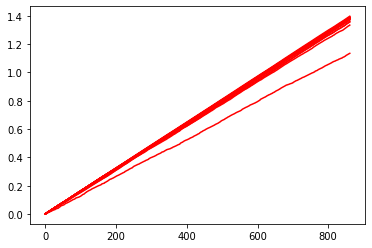

In [ ]:
if __name__ == '__main__':
    Accuracy=[]
    INPUT_DIM = 1 
    NUM_TS = 60
    NUM_CLASSES = len(np.unique(trainLabel))

    validation_sizes = [0.2]
    HIDDEN_DIMs = [128]
    num_masterIteration = 1
    #numEpochs = 500
    numEpochs = 20
    start(validation_sizes,HIDDEN_DIMs,num_masterIteration,numEpochs)
    print("Accuracy",Accuracy)